# Figure 2 - extracellular simulations

In [1]:
import neuron
from math import sin, cos
import numpy as np
import LFPy
import MEAutility as mu
import matplotlib.pyplot as plt
import neuroplotlib as npl
from pathlib import Path
import sys
import os
from pprint import pprint

In [2]:
from axon_velocity.models import insert_biophysics, insert_simple_biophysics, \
    get_default_biophysics_params, planarize_swc, save_cell, create_mea_probe, center_cell_xy
from axon_velocity import plot_amplitude_map, plot_peak_latency_map

In [3]:
%matplotlib inline

In [4]:
save_fig = True
fig_folder =  Path('figures') / "figure2"
fig_folder.mkdir(exist_ok=True, parents=True)

In [5]:
try:
    import neuron
except:
    print('NEURON is not installed.')

mechanism_folder = Path('..') / 'simulations' / 'mechanisms'

if not neuron.load_mechanisms(str(mechanism_folder)):
    print('Compile mod files in the mechanisms/ folder: from the mechanisms/ folder, run nrnivmodl')

In [6]:
# simple biophysiscs: dendrite - pas / soma/axon HH
# "complex" biophysics: dendrite - pas / soma - na + kv1 / axon - nax + kv1 
simple_biophysics = False

In [7]:
params_dict = get_default_biophysics_params()
pprint(params_dict)

{'Kv1_axon': 400,
 'Kv1_soma': 100,
 'celsius': 33,
 'cm': 1,
 'e_pas': -85,
 'ek': -98,
 'ena': 55,
 'g_pas': 6.666666666666667e-05,
 'na_axon': 500,
 'na_soma': 500,
 'ra': 80,
 'rm': 15000,
 'v_init': -85}


At this stage, one can also change the axial conductance (e.g. `sec.ra`), 
which likely affects the conduction velocity.

The `planar` variable decides wheter the z-axis is compressed (similar to a cell culture - `planar=True`) or the original morphology is used (`planar=False`).

In [8]:
planar = True
z_offset = 10 # distance between cell plane and mea plane
zspan = 20

In [9]:
morphology_dir = Path('..') / 'simulations' / 'neuromorpho' / 'allen_cell_types'

morph_id = '561096006'
original_morphology_path = [m for m in morphology_dir.iterdir() if not 
                            m.name.startswith('.') and morph_id in str(m)][0]
if planar:
    morphology_path = planarize_swc(original_morphology_path, span_um=zspan)
else:
    morphology_path = original_morphology_path

/Users/abuccino/Documents/Codes/ephys/BEL/axon_velocity/axon_velocity/models.py:290: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  swc_dtype = np.dtype([('id', np.int32, 1), ('type', np.int16, 1),


In [10]:
cell = LFPy.Cell(str(morphology_path), v_init=params_dict['v_init'], celsius=params_dict['celsius'],
                 Ra=params_dict['ra'], cm=params_dict['cm'], pt3d=True)

One point section Import3d_Section[2] ending at line 3 has been removed
One point section Import3d_Section[1] ending at line 2 has been removed


In [11]:
# center in the xy plane
center_cell_xy(cell)

<AxesSubplot:xlabel='x ($\\mu$m)', ylabel='y ($\\mu$m)'>

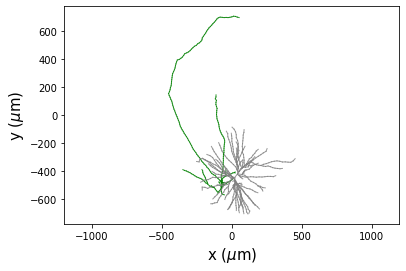

In [12]:
npl.plot_neuron(cell, plane='xy', color_axon='g')

### Insert cell biophysics

Here we make the cell active by inserting biophysical mechanisms.

In [13]:
if simple_biophysics:
    insert_simple_biophysics(cell)
else:
    insert_biophysics(cell, params_dict)

### Stimulating the cell

We can now add some stimulation. The stimulation can be a current clamp `iclamp` or synaptic inputs `syn`. The `stim_point` is where the cell will be stimulated (the closest cell segment to the `stim_point` is used).

In [14]:
stim = 'syn' # or syn
# stimulate on the soma
stim_idx = cell.somaidx

syn_input_times = np.arange(2, 5)

syn_params = {'idx' : stim_idx,
              'e' : 0,                                # reversal potential
              'syntype' : 'ExpSyn',                   # synapse type
              'tau' : 2,                              # syn. time constant ms
              'weight' : 0.05,                         # syn. weight
              'record_current' : True                 # syn. current record
    }
clamp_params = {'idx' : stim_idx,
                'pptype' : 'IClamp',                   # IClamp point process
                'dur' : 300,                            # dur in ms
                'amp' : 2,                             # amp in nA
                'delay' : 5                            # delay in ms
    }

In [15]:
if stim == 'syn':
    synapse = LFPy.Synapse(cell, **syn_params)
    synapse.set_spike_times(np.array(syn_input_times))
else:
    clamp = LFPy.StimIntElectrode(cell=cell, **clamp_params)

if not planar:
    shift_pos = np.min(cell.z) - z_offset
    shift_neg = np.max(cell.z) + z_offset

    if np.abs(shift_pos) > np.abs(shift_neg):
        shift = shift_neg
    else:
        shift = shift_pos
else:
    shift = z_offset
    
print(f"z-position of MEA: {shift}")

### Define extracellular electrodes

Let's now define the extracellular electrodes using the [MEAutility](https://meautility.readthedocs.io/en/latest/) package.

In [17]:
mea_dim = 100  # n rows x n cols
mea_pitch = 17.5  # rows and cols pitch
elec_size = 5

hdmea = create_mea_probe(pitch=mea_pitch, dim=mea_dim, elec_size=elec_size, z_offset=z_offset)

electrode = LFPy.RecExtElectrode(cell, probe=hdmea, n=10)

### Run the simulation

By passing the `electrode` argument `LFPy` also computes extracellular potentials. The `rec_vmem` argument allows to measure the membrane potenrtial at all segments.

In [18]:
cell.simulate(probes=[electrode], rec_vmem=True)

In [19]:
eap = electrode.data * 1000  # mV --> uV

In [20]:
# cutout single template
fs = 1 / cell.dt
ms_before = 2
ms_after = 10

min_chan, min_idx = np.unravel_index(np.argmin(eap), eap.shape)

In [21]:
eap_cut = eap[:, min_idx - int(ms_before * fs): min_idx + int(ms_after * fs)]

In [27]:
intra_tidxs = slice(min_idx - int(ms_before * fs), min_idx + int(ms_after * fs))

### Plots

1. Plot MEA and overlaid morphology

Text(-880, -1000, '100 $\\mu$m')

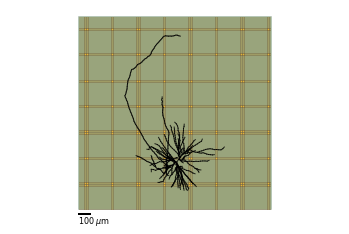

In [22]:
fig1, ax1 = plt.subplots(1, 1)

ax1 = mu.plot_probe(hdmea, type='planar', ax=ax1)
npl.plot_neuron(cell, plane='xy', color='k', ax=ax1)
ax1.axis('off')

# add scalebar
ax1.plot([-870, -770], [-920, -920], color='k', lw=2)
ax1.text(-880, -1000, "100 $\mu$m", fontsize=8)

2. Plot amplitude map

In [23]:
template = eap_cut
locations = hdmea.positions[:, :-1]  # save only x-y positions

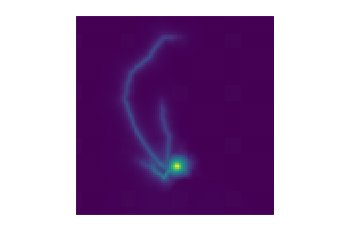

In [24]:
fig2, ax2 = plt.subplots(1, 1)
ax2 = plot_amplitude_map(template, locations, ax=ax2, log=True)

3. Insets with intra and extra potential

In [25]:
pos1 = [-200, -375]
pos2 = [-311, -132]
pos3 = [-400, 375]
pos4 = [-30, 685]

inset_positions = [pos1, pos2, pos3, pos4]s

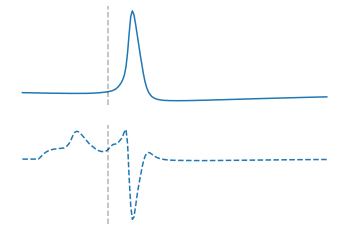

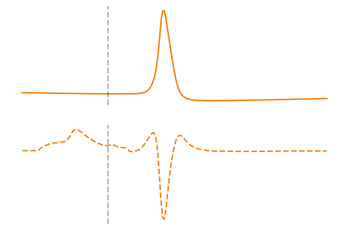

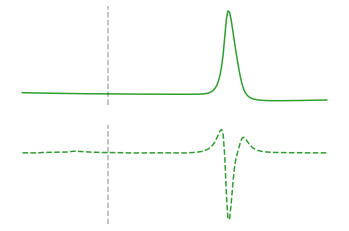

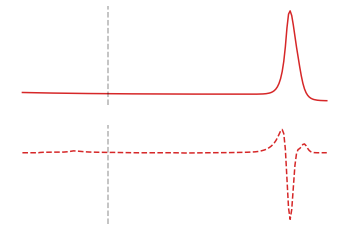

In [28]:
inset_figs = []
for i, pos in enumerate(inset_positions):
    extra_el_idx = hdmea.get_closest_electrode_idx([pos[0], pos[1], 0])
    cell_idx = cell.get_closest_idx(pos[0], pos[1], 0)
    
    ax2.plot(np.mean(cell.x[cell_idx]), np.mean(cell.y[cell_idx]), color=f"C{i}", marker='o')
    
    fig_in, axs = plt.subplots(2, 1)
    axs[0].plot(cell.vmem[cell_idx, intra_tidxs], color=f"C{i}", ls='-')
    axs[1].plot(eap_cut[extra_el_idx], color=f"C{i}", ls='--')
    
    axs[0].axvline(min_idx, color='k', ls='--', alpha=0.3)
    axs[1].axvline(min_idx, color='k', ls='--', alpha=0.3)
    
    axs[0].axis('off')
    axs[1].axis('off')
    
    inset_figs.append(fig_in)

### Save figures

In [30]:
if save_fig:
    fig1.savefig(fig_folder / "panelA_mea-neuron.png", dpi=300)
    fig2.savefig(fig_folder / "panelB_amp-map.png", dpi=300)    
    
    for i, inset in enumerate(inset_figs):
        inset.savefig(fig_folder / f"inset-{i}.pdf")